In [27]:
import pandas as pd
from IPython.display import Markdown
import prompts
import utils
import json
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
reload(utils)

<module 'utils' from '/usr/local/google/home/raulramos/projects/llmrouting/utils.py'>

In [28]:
metrics = ['groundness', 'summarization', 'text_quality', 'verbosity' ]
models = ['gemini-2.5-flash-preview-05-20', 'meta/llama-4-scout-17b-16e-instruct-maas']

In [36]:
data_file = 'dolly_15k_extended_small_3k.h5'
d = pd.read_hdf(data_file)
d.head()

,instruction,context,response,category,gemini-2.5-flash-preview-05-20::response,gemini-2.5-flash-preview-05-20::code,meta/llama-4-scout-17b-16e-instruct-maas::response,meta/llama-4-scout-17b-16e-instruct-maas::code,text_embeddings,cluster
4132,A las vegas seven days trip itinerary includin...,,A las vegas 7-day trip from Bangalore to Las V...,creative_writing,Planning a 7-day Las Vegas trip for 5 friends ...,ok,A 7-day trip to Las Vegas for a group of 5 fri...,ok,"[-0.002273174934089184, -0.005446048453450203,...",3
1325,When is the best time to visit Chicago?,,The best time to visit Chicago is during the S...,general_qa,"The ""best"" time to visit Chicago really depend...",ok,The best time to visit Chicago depends on your...,ok,"[-0.04216368868947029, -0.0008369883289560676,...",3
274,What types of problems in government could AI ...,The potential uses of AI in government are wid...,The potential uses of AI in government are wid...,closed_qa,"Based on Mehr's suggestions, AI could be used ...",ok,"According to Mehr, AI can be used to solve the...",ok,"[-0.008826622739434242, -0.001754036988131702,...",0
1305,"Based on this paragraph, please summarize Corm...","McCarthy uses punctuation sparsely, even repla...",Cormac McCarthy is known for his preference to...,closed_qa,"Based on the paragraph, Cormac McCarthy's use ...",ok,Here is a summary of Cormac McCarthy's use of ...,ok,"[0.01152744609862566, 0.008928683586418629, 0....",1
4697,"Which of these colors are primary colors: Red,...",,"There are three primary colors which are Red, ...",classification,The primary colors (in the traditional **RYB**...,ok,The primary colors from your list are:\n\n1. *...,ok,"[-0.023845836520195007, 0.008111131377518177, ...",6


In [70]:
di = d.sample(1).iloc[0]
print (di.context)
print (di.instruction)


What is the difference between solar power and hydrogen fuel cell?  What are the advantages of hydrogen?


In [ ]:
Ram was asked to repeat after the speaker. Speaker: Red, Ram: Red. Speaker: Blue, Ram: Blue. Speaker: Green, Ram: Green. Speaker: What's your name? , Ram: Ram

What went wrong here?

## global metrics

In [4]:
reload(utils)
r = {}
for m in metrics:
    z = pd.read_hdf(f'{data_file[:-3]}_{m}.h5')
    r[m] = pd.Series([utils.extract_json_rating(i) for i in z.response.values]).value_counts()
r = pd.DataFrame(r).fillna(0)

In [5]:
r

,groundness,summarization,text_quality,verbosity
-1.00,804.0,1764.0,2256.0,1967.0
-0.80,1.0,0.0,0.0,0.0
-0.75,5.0,0.0,0.0,0.0
-0.50,21.0,0.0,7.0,0.0
-0.25,0.0,0.0,1.0,0.0
-0.20,3.0,0.0,6.0,0.0
-0.10,0.0,0.0,12.0,0.0
0.00,1568.0,162.0,282.0,139.0
0.20,1.0,0.0,1.0,0.0
0.50,6.0,0.0,42.0,0.0


In [6]:
z

,prompt,id,response,code
0,\n# Instruction\nYou are an expert evaluator. ...,4132,## Evaluation\n\n### Response A Analysis\n**Ve...,ok
1,\n# Instruction\nYou are an expert evaluator. ...,1325,## Evaluation:\n\n**STEP 1: Analyze Response A...,ok
2,\n# Instruction\nYou are an expert evaluator. ...,274,## Evaluation\n### STEP 1: Analyze Response A ...,ok
3,\n# Instruction\nYou are an expert evaluator. ...,1305,## Evaluation\n\n### Response A Analysis\nResp...,ok
4,\n# Instruction\nYou are an expert evaluator. ...,4697,"```json\n{\n ""rating"": -1\n}\n```\n\n## Explan...",ok
...,...,...,...,...
2995,\n# Instruction\nYou are an expert evaluator. ...,2413,**Evaluation:**\n\n**STEP 1: Analyze Response ...,ok
2996,\n# Instruction\nYou are an expert evaluator. ...,11517,**Evaluation:**\n\n**STEP 1: Analyze Response ...,ok
2997,\n# Instruction\nYou are an expert evaluator. ...,8665,* **STEP 1: Analyze Response A based on the ...,ok
2998,\n# Instruction\nYou are an expert evaluator. ...,8697,## Evaluation\n\n### STEP 1: Analyze Response ...,ok


In [7]:
m0 = r.loc[[i for i in r.index if i<=-.5]].sum()
m0.name = models[0]
m1 = r.loc[[i for i in r.index if i>=.5]].sum()
m1.name = models[1]
mn = r.loc[[i for i in r.index if (i<.5) and (i>-.5)]].sum()
mn.name = 'same'

mm = pd.DataFrame([m0,mn,m1])
mm

,groundness,summarization,text_quality,verbosity
gemini-2.5-flash-preview-05-20,831.0,1764.0,2263.0,1967.0
same,1572.0,162.0,302.0,139.0
meta/llama-4-scout-17b-16e-instruct-maas,313.0,338.0,239.0,509.0


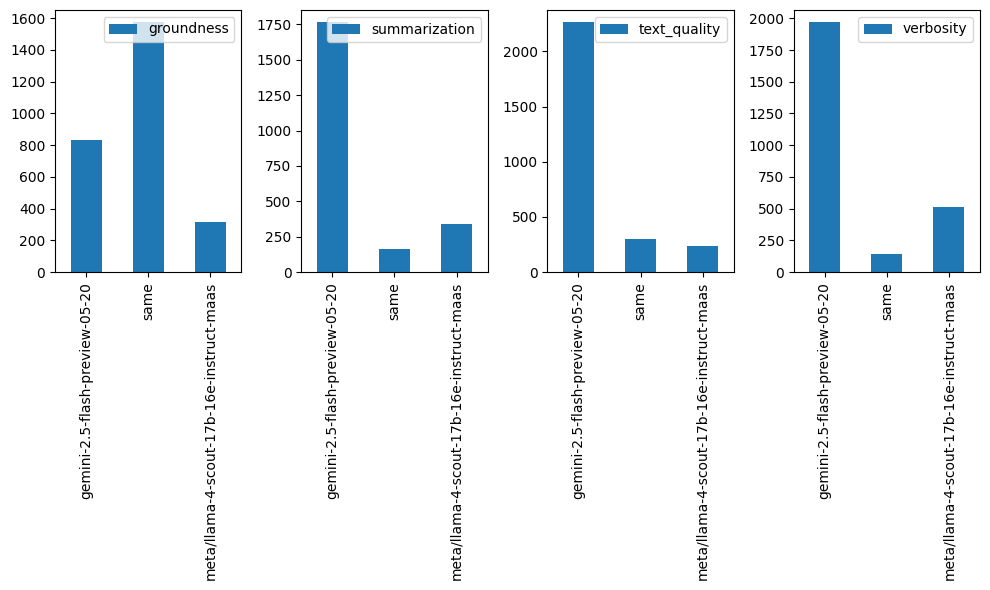

In [8]:
fig, axs = plt.subplots(1, 4, figsize=(10,6))
for i,metric in enumerate(metrics):
    mm[[metric]].plot(kind='bar', ax=axs[i])
plt.tight_layout()

# per cluster

In [9]:
clusters = sorted(np.unique(d.cluster.values))
clusters

[np.int32(0),
 np.int32(1),
 np.int32(2),
 np.int32(3),
 np.int32(4),
 np.int32(5),
 np.int32(6),
 np.int32(7)]

In [10]:
cluster = 0
cluster_idxs = d[d.cluster==cluster].index

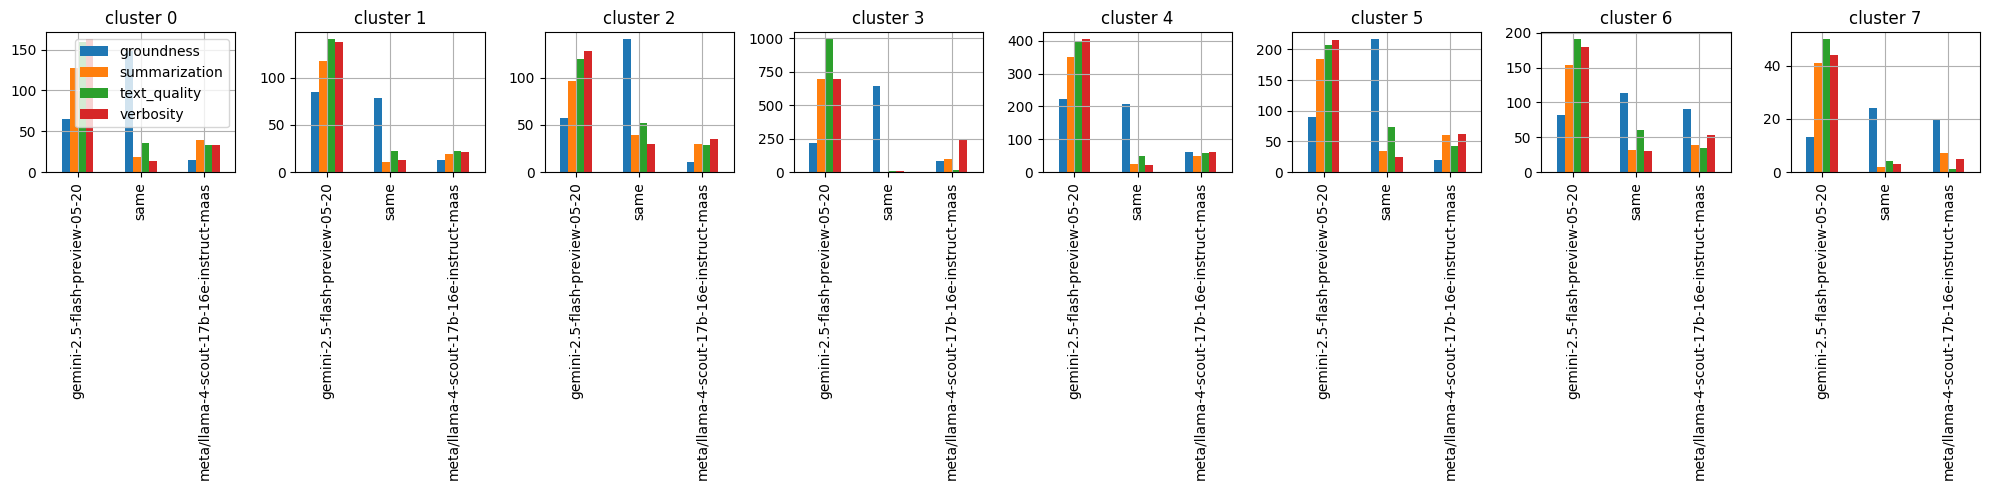

In [13]:
fig, axs = plt.subplots(1, len(clusters), figsize=(20,5))

for i in range(len(clusters)):
    cluster = clusters[i]
    cluster_idxs = d[d.cluster==cluster].index
    r = {}
    for m in metrics:
        z = pd.read_hdf(f'{data_file[:-3]}_{m}.h5')
        z = z[z['id'].isin(cluster_idxs)]
        r[m] = pd.Series([utils.extract_json_rating(i) for i in z.response.values]).value_counts()
    r = pd.DataFrame(r).fillna(0)
    m0 = r.loc[[i for i in r.index if i<=-.5]].sum()
    m0.name = models[0]
    m1 = r.loc[[i for i in r.index if i>=.5]].sum()
    m1.name = models[1]
    mn = r.loc[[i for i in r.index if (i<.5) and (i>-.5)]].sum()
    mn.name = 'same'
    
    mm = pd.DataFrame([m0,mn,m1])

    
    mm.plot(kind='bar', ax=axs.flatten()[i], legend=i==0, title = f'cluster {cluster}', grid=True)
    
plt.tight_layout()

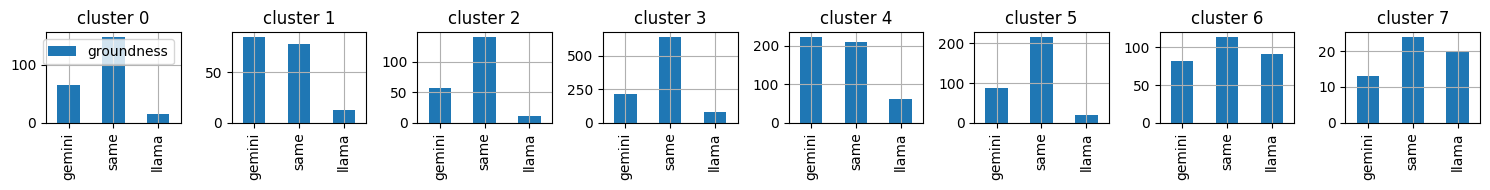

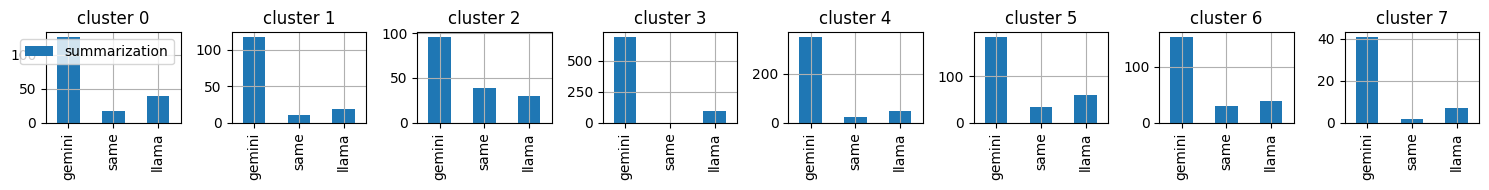

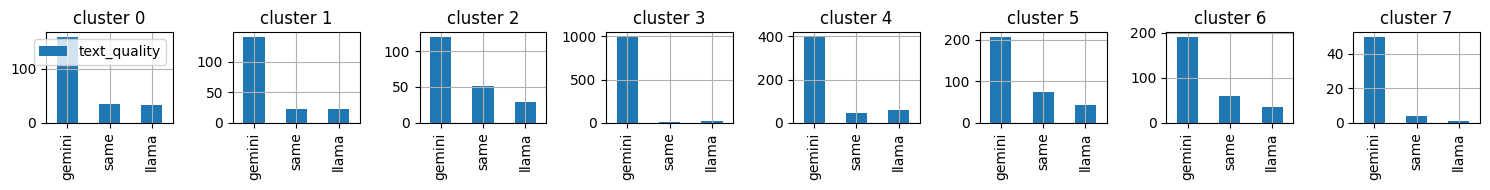

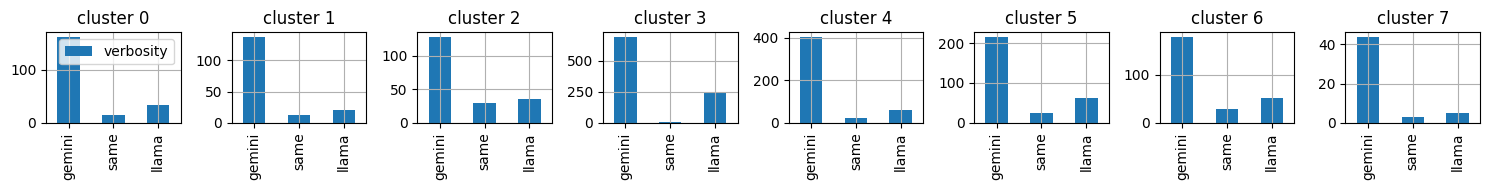

In [26]:

for m in metrics:
    fig, axs = plt.subplots(1, len(clusters), figsize=(15,2))
    for i in range(len(clusters)):
        cluster = clusters[i]
        cluster_idxs = d[d.cluster==cluster].index
        r = {}
        z = pd.read_hdf(f'{data_file[:-3]}_{m}.h5')
        z = z[z['id'].isin(cluster_idxs)]
        r[m] = pd.Series([utils.extract_json_rating(i) for i in z.response.values]).value_counts()
        r = pd.DataFrame(r).fillna(0)
        m0 = r.loc[[i for i in r.index if i<=-.5]].sum()
        m0.name = models[0]
        m1 = r.loc[[i for i in r.index if i>=.5]].sum()
        m1.name = models[1]
        mn = r.loc[[i for i in r.index if (i<.5) and (i>-.5)]].sum()
        mn.name = 'same'
        
        mm = pd.DataFrame([m0,mn,m1])
    
        
        mm.plot(kind='bar', ax=axs.flatten()[i], legend=i==0, title = f'cluster {cluster}', grid=True)
        axs[i].set_xticks([0,1,2],['gemini', 'same', 'llama'])
    plt.tight_layout()